### Tradução Automática de Texto

Link dataset: http://www.manythings.org/anki/

#### Importação das Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split

from keras import  layers  
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer

#### Importação dos Dados

In [ ]:
path = '/content/drive/MyDrive/Trabalho - Deep Learning/Texto/por-eng/por.txt'
df = pd.read_table(path, header=None, names=['ingles', 'portugues', 'none'])
df.head()

,ingles,portugues,none
0,Go.,Vai.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Vá.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Hi.,Oi.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Run!,Corre!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run!,Corra!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [ ]:
df = df[['ingles', 'portugues']]

In [ ]:
print(f'Amostras: {df.shape[0]}')

Amostras: 179252


#### Remoção de Caracteres

In [ ]:
pre_process = lambda x: re.sub(r'[^\w\s]', '', x.lower())

In [ ]:
df['ingles'] = df['ingles'].apply(pre_process)
df['portugues'] = df['portugues'].apply(pre_process)

#### Tokenização

In [ ]:
def tokenization(text):
    tokens = Tokenizer()
    tokens.fit_on_texts(text)
    return tokens

In [ ]:
ing_tok = tokenization(df['ingles'])
por_tok = tokenization(df['portugues'])

In [ ]:
vocab_ing = len(ing_tok.word_index) + 1
vocab_por = len(por_tok.word_index) + 1

print(f'Tamanho vocabulário Inglês: {vocab_ing}')
print(f'Tamanho vocabulário Português: {vocab_por}')

Tamanho vocabulário Inglês: 13130
Tamanho vocabulário Português: 23008


#### Análise das Sentenças

In [ ]:
size_sentence = lambda x: len(x.split())

In [ ]:
df['size_ing'] = df['ingles'].apply(size_sentence)
df['size_por'] = df['portugues'].apply(size_sentence)

In [ ]:
print(df['size_ing'].max())
print(df['size_por'].max())

35
33


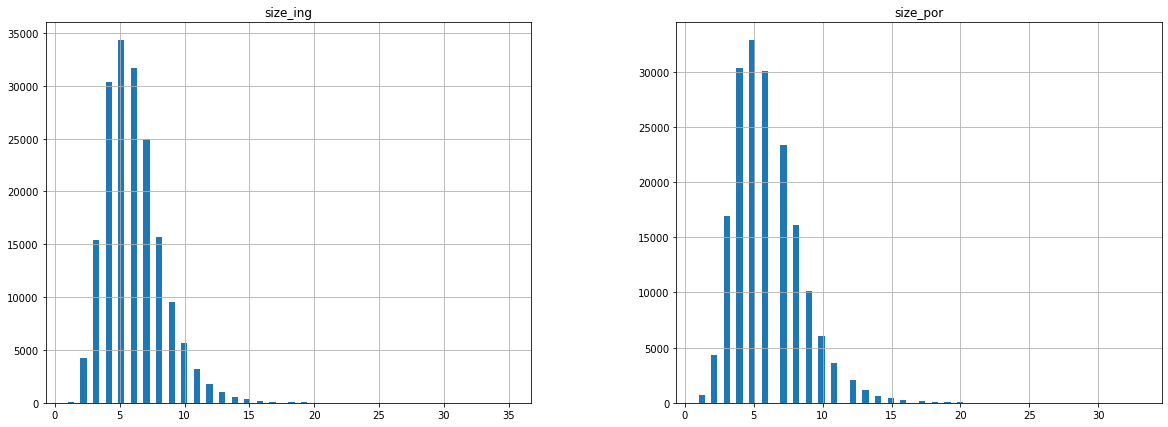

In [ ]:
df[['size_ing', 'size_por']].hist(bins=70, figsize=(20, 7));

#### Vetorização

In [ ]:
def vectorize(serie, size, seq_leng, eng=True):
  vector = np.zeros((size, seq_leng))
  for i, sentence in enumerate(serie):
    for j, word in enumerate(sentence.split()):
      if j == 13:
        break
      if eng:
        vector[i, j] = ing_tok.word_index[word]
      else:
        vector[i, j] = por_tok.word_index[word]
  return vector

In [ ]:
size = df.shape[0]

In [ ]:
seq_eng = vectorize(df['ingles'], size, 13)
seq_por = vectorize(df['portugues'], size, 13, eng=False)

#### Divisão dos Dados

In [ ]:
train_eng, test_eng, train_por, test_por = train_test_split(seq_eng, seq_por, test_size=0.2, random_state=42)

#### Criação do Modelo

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_ing, 512, input_length=13, mask_zero=True))
model.add(layers.LSTM(512))
model.add(layers.RepeatVector(13))
model.add(layers.LSTM(512, return_sequences=True))
model.add(layers.Dense(vocab_por, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 512)           6722560   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 13, 512)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 13, 512)           2099200   
                                                                 
 dense (Dense)               (None, 13, 23008)         11803104  
                                                                 
Total params: 22,724,064
Trainable params: 22,724,064
Non-trainable params: 0
____________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

#### Treino

In [ ]:
filename = '/content/drive/MyDrive/Trabalho - Deep Learning/Texto/modelv2.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# train model
history = model.fit(train_eng, train_por.reshape(train_por.shape[0], train_por.shape[1], 1),
                    epochs=30, 
                    batch_size=512, 
                    validation_split=0.2, 
                    callbacks=[checkpoint], 
                    verbose=1)

#### Curva de Aprendizagem

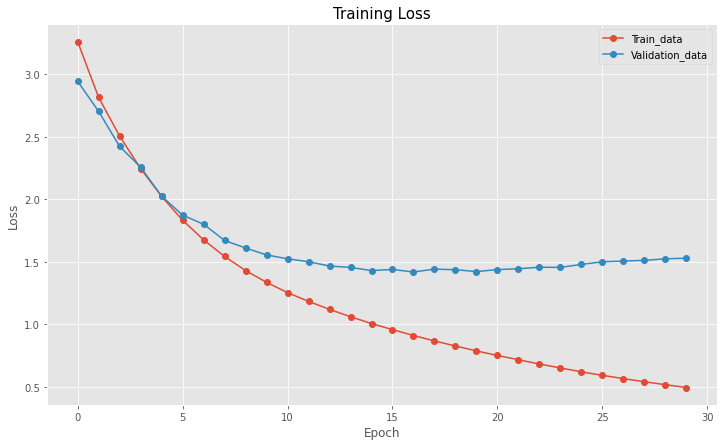

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], '-o')
plt.plot(history.history['val_loss'], '-o')
plt.legend(['Train_data','Validation_data'])
plt.title('Training Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show();

#### Avaliação

In [ ]:
model.load_weights(filename)

In [ ]:
loss = model.evaluate(test_eng, test_por.reshape(test_por.shape[0], test_por.shape[1], 1))

1121/1121 [==============================] - 10s 9ms/step - loss: 1.4223


#### Predição

In [ ]:
y_pred = np.argmax(model.predict(test_eng[:20]), axis=-1)

In [ ]:
def transl(encode):
  trad = []
  por = []
  for y in encode:
    for t in y:
      if t == 0:
        break
      trad.append(por_tok.index_word[t])
    por.append(' '.join(trad))
    trad.clear()
  return por

In [ ]:
dict_trad = { 'por_pred': transl(y_pred), 'por_orig' : transl(test_por[:20])}

In [ ]:
df_trad = pd.DataFrame(dict_trad)
df_trad

,por_pred,por_orig
0,tom e mary são são amigos melhores melhores,tom e mary são nossos melhores amigos
1,ele estava,ele estava atónito
2,ela sorriu no espelho,ela sorriu para si mesma no espelho
3,quero quero ouvir o resto da,eu quero ouvir o resto da estória
4,tom está está lá de dentro,o tom está lá em cima dormindo
5,estou ficando alto,estou ficando alta
6,eu pensei eu estivesse sozinho,pensei que estivesse sozinho
7,o tom a cantar,tom começou a cantar
8,quem está o cachorro do estava,quem deixou o cachorro trancado para fora
9,isso isso isso isso isso,isso dói para
